<a href="https://www.kaggle.com/code/ainurrohmanbwx/amazon-customer-analytics?scriptVersionId=146240999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Data analysis on the Amazon Customer dataset is a critical step in understanding and optimizing the world's largest e-commerce platform, Amazon. In this analysis, we will employ the ETL (Extract, Transform, Load) method to unearth valuable insights from Amazon customer data. We will explore how Amazon operates in recommending products to users, analyze user behavior to enhance the shopping experience, conduct sentiment analysis to understand user sentiments toward Amazon's products and services, and identify top-performing products based on the best reviews. This analysis will help us gain a deeper understanding of the dynamics of the e-commerce market and Amazon's strategies to maintain its position as an industry leader.

# Load Data (Extract)

In [1]:
# Disable warning

import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import sqlite3

con = sqlite3.connect("/kaggle/input/amazon-customer-reviews/database.sqlite")

In [3]:
type(con)

sqlite3.Connection

In [4]:
import pandas as pd

amazon = pd.read_sql_query("SELECT * FROM reviews", con)

In [5]:
amazon.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Features explanation:

- **Id**: this is a feature for unique identification for each review in the database.
- **ProductId**: this is a feature for unique identification for the product being reviewed.
- **UserId**: this is a feature for unique identification for users who provide reviews.
- **ProfileName**: this is a feature that contains the username or profile name of the user who provided the review.
- **HelpfulnessNumerator**: this is a feature that contains the number of people who found this review useful or helpful.
- **HelpfulnessDenominator**: this is a feature that contains the total number of people who saw this review or tried to rate it, not just those who found it useful.
- **Score**: this is a feature that contains ratings or ratings given by users for the products being reviewed.
- **Time**: this is the time feature when the review was created or published. This can be used to track when the review was written.
- **Summary**: this is a short summary feature of the review. It provides a quick overview of what users are reviewing.
- **Text**: this is a short summary feature of the review. It provides a quick overview of what users are reviewing.

In [6]:
amazon.shape

(568454, 10)

In [7]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Data Preprocessing (Transform)

#### Testing whether the Helpfulness Numerator feature is greater than the Helpfulness Denominator feature?

In the context of review data, it should not be possible to have a HelpfulnessNumerator that is larger than the HelpfulnessDenominator, because that would mean that more people found the review useful than actually saw or rated the review.

In [8]:
for index, row in amazon.iterrows():
    helpfulness_numerator = row['HelpfulnessNumerator']
    helpfulness_denominator = row['HelpfulnessDenominator']

    if helpfulness_numerator > helpfulness_denominator:
        print(f"Error in row {index}: HelpfulnessNumerator ({helpfulness_numerator}) is greater than HelpfulnessDenominator ({helpfulness_denominator})")

Error in row 44736: HelpfulnessNumerator (3) is greater than HelpfulnessDenominator (2)
Error in row 64421: HelpfulnessNumerator (3) is greater than HelpfulnessDenominator (1)


Because there is a HelpfulnessNumerator row that is greater than the HelpfulnessDenominator, we skip it

In [9]:
amazon = amazon[amazon['HelpfulnessNumerator'] <= amazon['HelpfulnessDenominator']]

In [10]:
amazon.shape

(568452, 10)

#### Is there any duplicate data?

In analyzing Amazon reviews data, avoiding duplication in features such as UserId, ProfileName, Time, and Text is important because it can obscure variations in the data and interfere with initial understanding of patterns and trends in the dataset.

In [11]:
if amazon.duplicated(['UserId', 'ProfileName', 'Time', 'Text']).any():
    print(f"There are as many as {amazon.duplicated(['UserId', 'ProfileName', 'Time', 'Text']).sum()} duplicate data.")
else:
    print("There are no duplicate data.")

There are as many as 174521 duplicate data.


In [12]:
# Drop duplicate data

amazon = amazon.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])

In [13]:
# Check again

if amazon.duplicated(['UserId', 'ProfileName', 'Time', 'Text']).any():
    print(f"There are as many as {amazon.duplicated(['UserId', 'ProfileName', 'Time', 'Text']).sum()} duplicate data.")
else:
    print("There are no duplicate data.")

There are no duplicate data.


In [14]:
amazon.shape

(393931, 10)

#### Are there any missing values?

In [15]:
# Check for missing values
missing_values = amazon.isnull().sum()

# Display columns with missing values and the count of missing values
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("Columns with missing values:")
    for column, count in missing_values.items():
        print(f"{column}: {count} missing values")
else:
    print("There are no columns with missing value")

There are no columns with missing value


#### Is there an incorrect data type?

In [16]:
amazon.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

If we observe each of the features above, something looks strange about the `time` feature, namely the data type is int64, it should be datetime. The solution is that we must first adjust the data type.

In [17]:
pd.to_datetime(amazon['Time'])

0        1970-01-01 00:00:01.303862400
1        1970-01-01 00:00:01.346976000
2        1970-01-01 00:00:01.219017600
3        1970-01-01 00:00:01.307923200
4        1970-01-01 00:00:01.350777600
                      ...             
568449   1970-01-01 00:00:01.299628800
568450   1970-01-01 00:00:01.331251200
568451   1970-01-01 00:00:01.329782400
568452   1970-01-01 00:00:01.331596800
568453   1970-01-01 00:00:01.338422400
Name: Time, Length: 393931, dtype: datetime64[ns]

If we observe, there is another number behind the second, it is called the fraction of a second. This seconds action provides more details about the time. Because all we need is day, month and year. So we take the date, month and year.

In [18]:
amazon['Time'] = pd.to_datetime(amazon['Time'], unit='s')
amazon['Time']

0        2011-04-27
1        2012-09-07
2        2008-08-18
3        2011-06-13
4        2012-10-21
            ...    
568449   2011-03-09
568450   2012-03-09
568451   2012-02-21
568452   2012-03-13
568453   2012-05-31
Name: Time, Length: 393931, dtype: datetime64[ns]

# Let's analyze the data (Load)

#### How does Amazon recommend products?

In [19]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In observing how Amazon recommends products, we use 'UserId' instead of 'ProfileName', why? Here's why:
- **User Uniqueness**: 'UserId' is a unique identification for each user. This ensures that you have clear information about each user individually.
- **Ease of Processing**: Using 'UserId' makes it easier to automatically group reviews and user behavior.
- **Consistency**: 'ProfileName' may change over time or may not accurately reflect user preferences.
- **Privacy**: Using 'ProfileName' may reveal more personal information about the user than intended.

In [20]:
amazon['UserId'].nunique()

256059

In [21]:
recommend = amazon.groupby(['UserId']).agg({'Summary':'count', 'Text':'count', 'Score':'count', 'ProductId':'count'}).sort_values(by="ProductId", ascending=False)

In [22]:
#rename columns
recommend.columns = ['Number_of_summaries', 'Num_text', 'Avg_score', 'Prods_purchased']

In [23]:
recommend.head()

,Number_of_summaries,Num_text,Avg_score,Prods_purchased
UserId,,,,
AY12DBB0U420B,329,329,329,329
A3OXHLG6DIBRW8,278,278,278,278
A281NPSIMI1C2R,259,259,259,259
A1YUL9PCJR3JTY,214,214,214,214
A1Z54EM24Y40LL,211,211,211,211


In [24]:
# show top 10 users

top_10_users = recommend.index[0:10]
top_10_users

Index(['AY12DBB0U420B', 'A3OXHLG6DIBRW8', 'A281NPSIMI1C2R', 'A1YUL9PCJR3JTY',
       'A1Z54EM24Y40LL', 'A2MUGFV2TDQ47K', 'A3D6OI36USYOU1', 'AZV26LP92E6WU',
       'AKMEY1BSHSDG7', 'A2GEZJHBV92EVR'],
      dtype='object', name='UserId')

In [25]:
purchase_counts = recommend['Prods_purchased'][0:10].values
purchase_counts

array([329, 278, 259, 214, 211, 161, 146, 129, 119, 118])

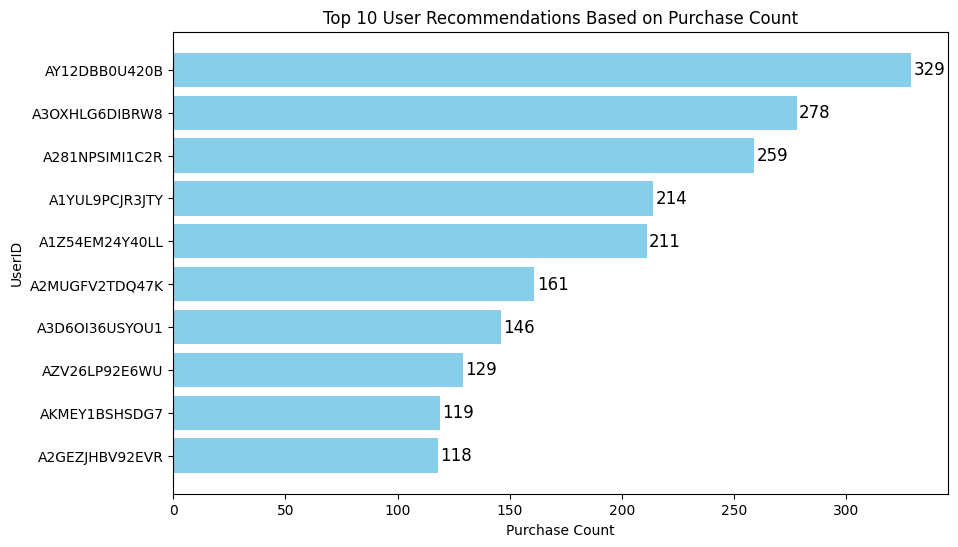

In [26]:
import matplotlib.pyplot as plt

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_users, purchase_counts, color='skyblue')

# Add labels to the axes
plt.xlabel('Purchase Count')
plt.ylabel('UserID')

# Add a title
plt.title('Top 10 User Recommendations Based on Purchase Count')

# Add values on the bars
for i, v in enumerate(purchase_counts):
    plt.text(v + 1, i, str(v), va='center', fontsize=12)

# Reverse the order so that the highest count is at the top
plt.gca().invert_yaxis()  
plt.show()

#### Which products have the best reviews?

In [27]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [28]:
len(amazon['ProductId'].unique())

67624

In [29]:
prod_count = amazon['ProductId'].value_counts().to_frame()
prod_count

,count
ProductId,
B007JFMH8M,912
B002QWP89S,630
B003B3OOPA,622
B001EO5Q64,566
B0013NUGDE,558
...,...
B002DNX4GO,1
B000FM2YU2,1
B001M1VA32,1


Determining the minimum threshold to determine best-selling sales is very subjective, in fact there are several techniques, apart from that it must involve expert domains. However, in this analysis, we do not discuss this in more depth. We agree that the threshold in this analysis is 500.

In [30]:
prod_count[prod_count['count']>500]

,count
ProductId,
B007JFMH8M,912
B002QWP89S,630
B003B3OOPA,622
B001EO5Q64,566
B0013NUGDE,558
B000KV61FC,556
B000UBD88A,542
B000NMJWZO,542
B005K4Q37A,541


In [31]:
freq_prods_ids = prod_count[prod_count['count']>500].index
freq_prods_ids

Index(['B007JFMH8M', 'B002QWP89S', 'B003B3OOPA', 'B001EO5Q64', 'B0013NUGDE',
       'B000KV61FC', 'B000UBD88A', 'B000NMJWZO', 'B005K4Q37A', 'B0090X8IPM',
       'B005ZBZLT4'],
      dtype='object', name='ProductId')

In [32]:
# filter dataframes that only have purchases above 500

amazon['ProductId'].isin(freq_prods_ids)

0         False
1         False
2         False
3         False
4         False
          ...  
568449    False
568450    False
568451    False
568452    False
568453    False
Name: ProductId, Length: 393931, dtype: bool

In [33]:
freq_prods = amazon[amazon['ProductId'].isin(freq_prods_ids)]
freq_prods

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
20982,20983,B002QWP89S,A21U4DR8M6I9QN,"K. M Merrill ""justine""",1,1,5,2011-10-18,addictive! but works for night coughing in dogs,my 12 year old sheltie has chronic brochotitis...
20983,20984,B002QWP89S,A17TDUBB4Z1PEC,jaded_green,1,1,5,2011-10-14,genuine Greenies best price,"These are genuine Greenies product, not a knoc..."
20984,20985,B002QWP89S,ABQH3WAWMSMBH,tenisbrat87,1,1,5,2011-09-28,Perfect for our little doggies,"Our dogs love Greenies, but of course, which d..."
20985,20986,B002QWP89S,AVTY5M74VA1BJ,tarotqueen,1,1,5,2011-09-24,dogs love greenies,"What can I say, dogs love greenies. They begg ..."
20986,20987,B002QWP89S,A13TNN54ZEAUB1,dcz2221,1,1,5,2011-09-23,Greenies review,This review is for a box of Greenies Lite for ...
...,...,...,...,...,...,...,...,...,...,...
563878,563879,B007JFMH8M,A366PSH7KFLRPB,TheRosySnail,0,0,5,2012-07-29,Yummy!,I loved these cookies and so did my kids. You ...
563879,563880,B007JFMH8M,A2KV6EYQPKJRR5,Kelley,0,0,5,2012-07-28,Quaker Soft Baked Cookies,This is a great tasting cookie. It is very sof...
563880,563881,B007JFMH8M,A3O7REI0OSV89M,Esme,0,0,4,2012-07-28,Delicious!,These are great for a quick snack! They are sa...
563881,563882,B007JFMH8M,A9JS5GQQ6GIQT,Syne,0,0,5,2012-07-28,yummy,I love the Quaker soft baked cookies. The rea...


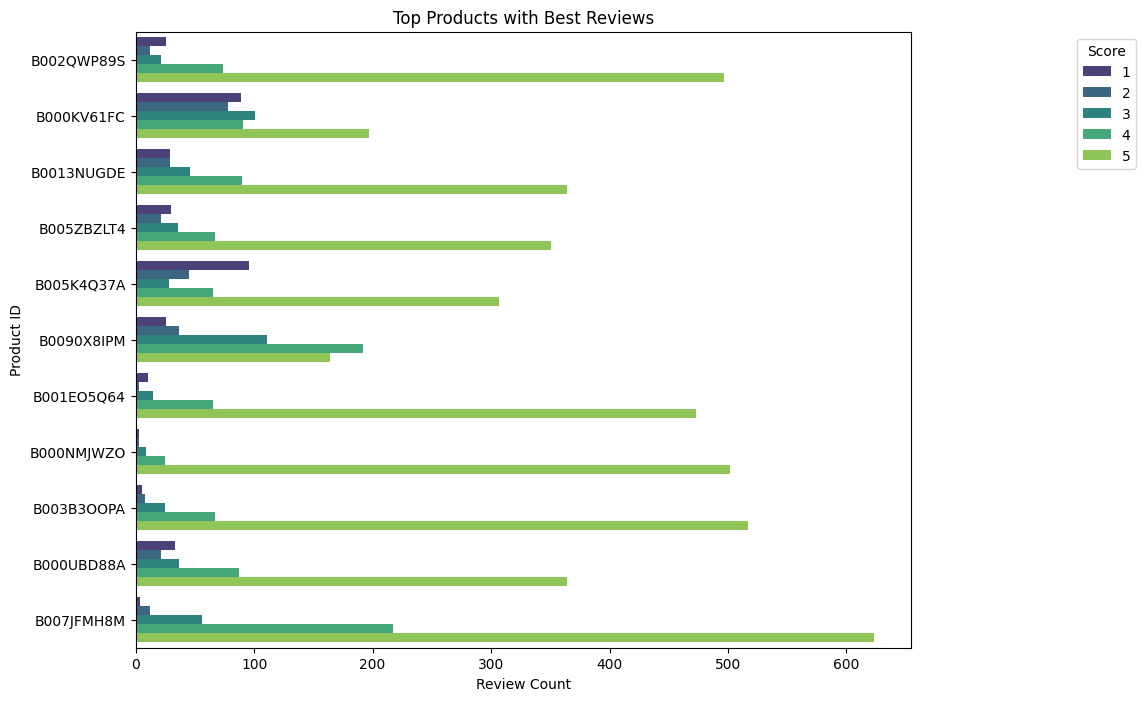

In [34]:
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Specify the number of colors from the colormap
n_colors = len(freq_prods['Score'].unique())
palette = sns.color_palette("viridis", n_colors)

# Create the countplot
ax = sns.countplot(y='ProductId', data=freq_prods, hue='Score', palette=palette)

# Add labels and title
ax.set_xlabel('Review Count')
ax.set_ylabel('Product ID')
ax.set_title('Top Products with Best Reviews')

# Customize legend
legend = ax.legend(title='Score', loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Customize the gridlines
sns.set(style="whitegrid")

# Show the plot
plt.show()

In [35]:
import plotly.express as px

# create interactive visualizations
data = freq_prods.groupby(['ProductId', 'Score']).size().reset_index(name='Count')

# Create an interactive bar chart using Plotly
fig = px.bar(data, y='ProductId', x='Count', color='Score', orientation='h', 
             labels={'ProductId': 'Product ID', 'Count': 'Review Count'},
             title='Top Products with Best Reviews')

# Customize the legend
fig.update_traces(marker_line_width=0)
fig.update_layout(legend_title_text='Score')

# Show the interactive plot
fig.show()

#### Understanding Amazon user behavior

In [36]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [37]:
x = amazon['UserId'].value_counts()
x

UserId
AY12DBB0U420B     329
A3OXHLG6DIBRW8    278
A281NPSIMI1C2R    259
A1YUL9PCJR3JTY    214
A1Z54EM24Y40LL    211
                 ... 
AAQPR1MSRXKTU       1
AGO81Z6PZSF7P       1
ALA84XWMTQBFT       1
A1G9DK8EUR36JC      1
A3LGQPJCZVL9UC      1
Name: count, Length: 256059, dtype: int64

In [38]:
amazon['Viewer_type'] = amazon['UserId'].apply(lambda user: "Frequent" if x[user]>50 else "Not Frequent")
amazon['Viewer_type']

0         Not Frequent
1         Not Frequent
2         Not Frequent
3         Not Frequent
4         Not Frequent
              ...     
568449    Not Frequent
568450    Not Frequent
568451    Not Frequent
568452    Not Frequent
568453    Not Frequent
Name: Viewer_type, Length: 393931, dtype: object

In [39]:
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Not Frequent
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent


In [40]:
freq = amazon[amazon['Viewer_type']=='Frequent']
not_freq = amazon[amazon['Viewer_type']=='Not Frequent']

In [41]:
freq['Score'].value_counts()/len(freq)*100

Score
5    61.605044
4    21.147681
3     9.585381
2     3.932464
1     3.729429
Name: count, dtype: float64

In [42]:
not_freq['Score'].value_counts()/len(not_freq)*100

Score
5    63.757986
4    14.071191
1     9.349850
3     7.507547
2     5.313426
Name: count, dtype: float64

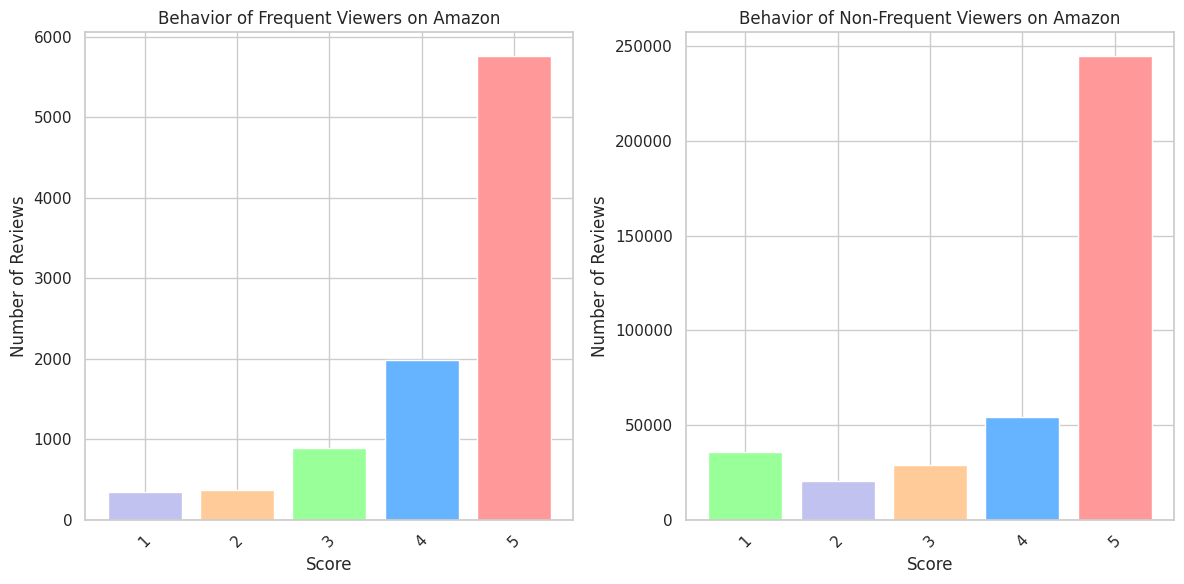

In [43]:
# Set colors and labels
freq_counts = freq['Score'].value_counts()
not_freq_counts = not_freq['Score'].value_counts()
freq_labels = freq_counts.index
not_freq_labels = not_freq_counts.index

# Set color palette
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# Set plot size
plt.figure(figsize=(12, 6))

# Plot frequency data
plt.subplot(1, 2, 1)
plt.bar(freq_labels, freq_counts, color=colors)
plt.title('Behavior of Frequent Viewers on Amazon')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)

# Plot non-frequency data
plt.subplot(1, 2, 2)
plt.bar(not_freq_labels, not_freq_counts, color=colors)
plt.title('Behavior of Non-Frequent Viewers on Amazon')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)

# Set overall layout
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
# Create dataframes for frequency and non-frequency data
freq_df = pd.DataFrame({'Score': freq_labels, 'Number of Reviews': freq_counts})
not_freq_df = pd.DataFrame({'Score': not_freq_labels, 'Number of Reviews': not_freq_counts})

# Create interactive bar charts for frequency and non-frequency data
fig = px.bar(freq_df, x='Score', y='Number of Reviews', color='Score',
             title='Behavior of Frequent Viewers on Amazon')
fig.update_xaxes(title_text='Score', tickangle=45)
fig.update_yaxes(title_text='Number of Reviews')
fig.update_layout(xaxis_title='Score', yaxis_title='Number of Reviews')

fig2 = px.bar(not_freq_df, x='Score', y='Number of Reviews', color='Score',
              title='Behavior of Non-Frequent Viewers on Amazon')
fig2.update_xaxes(title_text='Score', tickangle=45)
fig2.update_yaxes(title_text='Number of Reviews')
fig2.update_layout(xaxis_title='Score', yaxis_title='Number of Reviews')

# Combine the two charts into one interactive dashboard
from plotly.subplots import make_subplots

dashboard = make_subplots(rows=1, cols=2, subplot_titles=("Frequent Viewers", "Non-Frequent Viewers"))
dashboard.add_trace(fig.data[0], row=1, col=1)
dashboard.add_trace(fig2.data[0], row=1, col=2)

# Set the layout for the dashboard
dashboard.update_layout(showlegend=False, title_text="Amazon Viewer Behavior Analysis")

# Show the interactive dashboard
dashboard.show()

#### Which users often beat around the bush?

In [45]:
amazon.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Viewer_type'],
      dtype='object')

In [46]:
amazon[['UserId', 'ProductId', 'Text']]

,UserId,ProductId,Text
0,A3SGXH7AUHU8GW,B001E4KFG0,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,B000LQOCH0,This is a confection that has been around a fe...
3,A395BORC6FGVXV,B000UA0QIQ,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,B006K2ZZ7K,Great taffy at a great price. There was a wid...
...,...,...,...
568449,A28KG5XORO54AY,B001EO7N10,Great for sesame chicken..this is a good if no...
568450,A3I8AFVPEE8KI5,B003S1WTCU,I'm disappointed with the flavor. The chocolat...
568451,A121AA1GQV751Z,B004I613EE,"These stars are small, so you can give 10-15 o..."
568452,A3IBEVCTXKNOH,B004I613EE,These are the BEST treats for training and rew...


In [47]:
amazon['Text_length'] = amazon['Text'].apply(lambda text: len(text.split(' ')))

In [48]:
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent,49
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent,99
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Not Frequent,43
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent,30


In [49]:
freq = amazon[amazon['Viewer_type']=='Frequent']
not_freq = amazon[amazon['Viewer_type']=='Not Frequent']

In [50]:
freq

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,Frequent,22
44,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,2008-05-02,Great taste and convenience,We really like the McCann's steel cut oats but...,Frequent,44
46,47,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0,0,5,2007-10-19,good,Good oatmeal. I like the apple cinnamon the b...,Frequent,50
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,2011-09-19,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...,Frequent,134
141,142,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0,0,4,2011-04-03,Good Licorice,Twizzlers brand licorice is much better than t...,Frequent,47
...,...,...,...,...,...,...,...,...,...,...,...,...
568238,568239,B002OXLXLG,A1Z54EM24Y40LL,c2,0,0,5,2011-07-14,Great replacement for the Girl Scout version!,If you failed to purchase enough of the Mint G...,Frequent,111
568261,568262,B00374ZKQ0,A2GEZJHBV92EVR,History buff,0,0,5,2012-08-16,Very good alternative to sugar.,I have tried many of the no sugar sweeteners o...,Frequent,49
568317,568318,B0013Z0PTW,A1ODOGXEYECQQ8,Nuknuk,0,0,4,2008-11-17,Good Tasting Granola Bars,Most health bars taste awful. Fiber One Grano...,Frequent,65
568331,568332,B001BOAOLY,A36MP37DITBU6F,"Enchanted In Dixie ""Enchanted""",6,6,4,2009-06-08,GREAT ORGANIC Honey flavor Hard candy. Great c...,These are delicious organic hard candies. I on...,Frequent,60


In [51]:
import plotly.graph_objs as go

freq_data = freq['Text_length']
not_freq_data = not_freq['Text_length']

# Create the first subplot
fig = go.Figure()

fig.add_trace(go.Box(y=freq['Text_length'], name='Frequency'))

# Create the second subplot
fig.add_trace(go.Box(y=not_freq['Text_length'], name='Not Frequency'))

# Add layout and title
fig.update_layout(
    title='Box Plot of Text Length',
    xaxis=dict(title='User Type'),
    yaxis=dict(title='Text Length'),
)

# Show the interactive plot
fig.show()

#### Sentiment Analysis

In [52]:
from textblob import TextBlob

In [53]:
amazon.shape

(393931, 12)

In [54]:
sample = amazon[0:50000]

In [55]:
polarity = [TextBlob(text).sentiment.polarity if isinstance(text, str) else 0 for text in sample['Summary']]

In [56]:
len(polarity)

50000

In [57]:
sample.loc[:, 'Polarity'] = polarity

In [58]:
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length,Polarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent,49,0.7
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent,31,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent,99,0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Not Frequent,43,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent,30,0.8


In [59]:
sample_positive = sample[sample['Polarity']>0]
sample_negative = sample[sample['Polarity']<0]

In [60]:
from collections import Counter

Counter(sample_positive['Summary']).most_common(10)

[('Delicious!', 208),
 ('Delicious', 204),
 ('Great product', 100),
 ('Excellent', 85),
 ('Love it!', 81),
 ('Great', 81),
 ('Great Product', 77),
 ('Great!', 70),
 ('Good stuff', 51),
 ('Awesome', 50)]

In [61]:
Counter(sample_negative['Summary']).most_common(10)

[('Disappointed', 44),
 ('Disappointing', 32),
 ('Bland', 18),
 ('Awful', 17),
 ('Not what I expected', 17),
 ('Terrible', 15),
 ('Horrible', 15),
 ('disappointed', 15),
 ('Disgusting', 12),
 ('not good', 11)]